# Regresión de contaminación de Madrid usando redes neuronales.

### Guión para explorar el proyecto en este cuaderno



### Descripción del proyecto

Este proyecto aborda los datos temporales horarios del portal de datos abiertos de la ciudad de Madrid.

https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

Las redes neuronales ofrecen la capacidad de aprender patrones muy complejos, en apariencia de ruido matemático. Los datos de calidad del aire de Madrid, son paradigmáticos a este respecto.

El hecho de tener datos horarios ofrece la posibilidad de explorar la complejidad de los patrones de calidad del aire a la escala temporal mínima en que sucede la dinámica de los componentes atmosféricos y por tanto que la red aprenda de forma efectiva su evolución.

Adicionalmente, la serie temporal de una magnitud en el tiempo aunque se visualice de forma unidimensional es en realidad función de múltiples variables, normalmente desconocidas, que también pueden ser recabadas a la misma secuenciación temporal y que puedan apoyar la predicción.

Este prototipado expone precisamente la predicción del contaminante $NO_{2}$ medido de forma horaria en la estación de monitorización del aire de Plaza del Carmen, en Madrid centro, sustentado en paralelo por medidas horarias meteorológicas y usando el contaminante $O_{3}$. El Ozono es un contaminante intimamente ligado a la presencia del Dióxido de Nitrógeno y puede ser interesante explorar la capacidad de predición de la red con la entrada adicional de su presencia, también recogida por la estación de monitorización en Plaza del Carmen. 

### Librerias

En la celda contigua importamos las librerías que serán usadas a lo largo del proyecto

In [2]:
import pandas as pd
import numpy as np
import time
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, DotProduct, Matern, ConstantKernel

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sys
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, LSTM, GRU
from tensorflow.python.keras.layers import BatchNormalization, Activation,  ReLU, add
from tensorflow.python.keras import Sequential, Input, Model
from tensorflow import keras

### Adquisición de datos y visualización

El portal de datos abierto de Madrid no provee de API para descargar los datos de forma automatizada, sino que dispone de ficheros en diferentes formatos para que el usuario los procese. En particular, descargamos los datos horarios de calidad del aire y meteorológicos en ficheros .csv los cuales incorporan toda la información por meses.

El formato en que se almacena los datos aunque estandarizado en su base de datos, no están distribuidos por columnas para la etiqueta de cada contaminante/magnitud meteorológica y cada fila por fecha, que sería el formato más obvio para ser procesado usando la clase DataFrame de la librería pandas en python.

Por ello las celdas contiguas incorporan el código para procesar la información horaria de calidad del aire y de meteorología en un formato de columnas para cada magnitud y las filas las fechas-horas en que fueron medidas.

##### Comentario respecto los datos recogidos

Si bien los datos de contaminación atmosféricas están recogidos desde el año 2001, con modificaciones en las estaciones de monitorización de la red, los datos horarios meteorológicos están limitados a los años 2019,2020 y 2021. Esto va a suponer dos inconvenientes, primero una reducción grande del potencial conjunto de datos usados para el entrenamiento de la red ya que solo se podrán emplear los datos de contaminantes de los años 2019, 2020 y 2021 a pesar de tener datos para otros 15 años. El segundo inconveniente es que subyacente a los datos, la ciudad de Madrid ha presenciado notables cambios en la movilidad de la ciudad; primeramente, la implementación del area de Madrid Central en el año 2019, seguidamente el impacto del COVID-19 en el año 2020. Por ello, junto a que 3 años si bien son muchos datos horarios uniento a lo anterior la presencia de pocas muestras respecto las estaciones del año (los datos de contaminación tienen una marcada periodicidad anual) hacen que la red tenga que aprender de datos provenientes de fenómenos dispares. Si bien esto no será evaluado ni considerado, si que es de esperar que suponga una dificultad a la hora de generalizar la predicción al conjunto de test.

### Calidad del aire, datos horarios, volcado de datos brutos .csv a DataFrame

Los ficheros brutos descargados del portal de datos abiertos están en la carpeta datosHorariosContaminacion

In [ ]:
# La dirección de los datos diarios es la siguiente
directorioDatosHorarios = './datosHorariosContaminacion/'

# Lista con dataFrames de los datos en el formato ofrecido por la CAM
# Tenemos para todos los meses y años.
meses = np.array(['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic'])
years_csv = np.array(['_mo10.csv','_mo11.csv','_mo12.csv','_mo13.csv','_mo14.csv','_mo15.csv','_mo16.csv','_mo17.csv','_mo18.csv','_mo19.csv','_mo20.csv','_mo21.csv'])

# Se implementa el siguiente producto cartesiano para tener los nombres de todos los ficheros
ficheros = np.asarray([ [ mes+ycsv for mes in meses] for ycsv in years_csv[0:11]]).reshape(len(meses)*len(years_csv[0:11]))
# Esto es porque los datos no estan para los 12 meses del año 21 y por lo tanto la operación anterior sobre todos los años no devolvería una estuctura rectangular
ficheros = np.concatenate(( ficheros, np.asarray([ mes+years_csv[-1] for mes in meses[0:-2] ] )))
ficheros = ficheros.reshape(len(meses)*len(years_csv[0:11])+len(meses[0:10]))

print(ficheros)

datosHorariosAnuales_ls_pd = [ pd.read_csv(directorioDatosHorarios+fichero, sep =';') for fichero in ficheros]

# Se concatenan los dataframes
datosHorariosAnuales_pd = pd.concat(datosHorariosAnuales_ls_pd)

datosHorariosAnuales_pd

### Calidad del aire, datos horarios, selección de datos de interés en formato por columnas y fechas por filas a .csv

Aquí además de elegir las moléculas de interés (hay que conocer el código que el portal de datos abiertos le asociada cada una) nos aseguramos de coger solo fechas en los que hayan datos válidos. Por ejemplo el caso que se presenta recoge datos de Ozono y Dióxido de Nitrógeno. Pues el análisis en esta celda solo va a mantener aquellas fechas en los que existen fechas válidas de Ozono y Dióxido de Nitrógeno, puesto que en el entrenamiento no podemos incorporar datos con valores ausentes pero si es plausible ignorar la fecha completa.

In [ ]:
### Seleccionamos magnitud y estación
provincia = 28
municipio = 79
estacion = 35
magnitudes = [8,14] # NO2 y Ozono
nombresMagnitudes = ['NO2','O3']

datosHorariosAnualesEspecificos_pd = datosHorariosAnuales_pd[(datosHorariosAnuales_pd.PROVINCIA==provincia) &
                                                             (datosHorariosAnuales_pd.MUNICIPIO==municipio) & 
                                                             (datosHorariosAnuales_pd.ESTACION==estacion) & 
                                                             (datosHorariosAnuales_pd.MAGNITUD.isin(magnitudes))  ]


# A continuacion, se obtienen los datos Horarios
datosHorariosAnualesFechaEspecificos_pd = datosHorariosAnualesEspecificos_pd[['MAGNITUD','ANO','MES','DIA']+[f'H{i:>02}' for i in range(1,25)] + [f'V{i:>02}' for i in range(1,25)] ]

# Se crea una columna que resulte de concatenar mes y año, que vienen a ser un valor compartido de cuando hay medidas o no diarias
datosHorariosAnualesFechaEspecificos_pd['year_month_day'] = pd.to_datetime(datosHorariosAnualesFechaEspecificos_pd['DIA'].astype(str).values+
                                                                       '-'+datosHorariosAnualesEspecificos_pd['MES'].astype(str).values+
                                                                       '-'+datosHorariosAnualesEspecificos_pd['ANO'].astype(str).values,format='%d-%m-%Y')


# Se van a eliminar aquellos dias en los que no haya medidas para todas las magnitudes
# Hacemos un agrupado para poder separar por magnitud y ordenar cada dataframe por las fechas. Posteriormente extraer sus valores
agrupados_por_fecha = datosHorariosAnualesFechaEspecificos_pd.groupby('year_month_day')
dataFrames_por_fecha = [ agrupados_por_fecha.get_group(grupo) for grupo in agrupados_por_fecha.groups]
# De aqui deben eliminarse los dataframes por fecha que no contengan todas las magnitudes de interes
# Se hace de esta forma para evitar un error de que no puede compararse por etiquetas idénticas

n = len(dataFrames_por_fecha)
for _i, df in enumerate(dataFrames_por_fecha[::-1], 1):
    if not (collections.Counter(list(df['MAGNITUD'].values)) == collections.Counter(magnitudes)):
        dataFrames_por_fecha.pop(n - _i)

# Concatenamos de vuelta, ya habiendo eliminado aquellos días en los que uno u otro contaminante seleccionado están ausentes        
datosHorariosAnualesFechaEspecificos_pd = pd.concat(dataFrames_por_fecha)

# fechas propiamente dichas, que seran almacenadas como columna en el documento final
# No todos los archivos de .csv tienen información para todos los dias
# Debemos concatenar Series con los días en los que sí hay medidas
# Debemos restringir las fechas a una magnitud cualesquiera para evitar duplicados
anno_np = datosHorariosAnualesFechaEspecificos_pd[datosHorariosAnualesFechaEspecificos_pd.MAGNITUD==magnitudes[0]]['ANO'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
mes_np  = datosHorariosAnualesFechaEspecificos_pd[datosHorariosAnualesFechaEspecificos_pd.MAGNITUD==magnitudes[0]]['MES'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
dia_np  = datosHorariosAnualesFechaEspecificos_pd[datosHorariosAnualesFechaEspecificos_pd.MAGNITUD==magnitudes[0]]['DIA'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
anno_mes_dia_S = pd.Series(anno_np+mes_np+dia_np)
# Para cada fecha almacenada en la serie anterior, se deben tener fechas para cada hora (hasta 24 horas)
fechas_pd = pd.DataFrame({},dtype='datetime64',columns=['fecha'])
for fecha in anno_mes_dia_S.values:
    a_day_pd = pd.DataFrame(pd.date_range(start=fecha, periods=24,freq='H'),columns=['fecha'])
    fechas_pd = fechas_pd.append(a_day_pd)

# Registramos el número de fechas unívocas. Pero para cada fecha puede haber horas en los que las medidas de un contaminante sean validas pero la de otras no, ojo
registros = len(datosHorariosAnualesFechaEspecificos_pd.groupby(datosHorariosAnualesFechaEspecificos_pd.year_month_day.tolist(),as_index=False).size())

# Hacemos un agrupado para poder separar por magnitud y ordenar cada dataframe por las fechas. Posteriormente extraer sus valores
agrupados_por_magnitud = datosHorariosAnualesFechaEspecificos_pd.groupby('MAGNITUD')
dataFrames_por_magnitud = [ agrupados_por_magnitud.get_group(grupo).sort_values('year_month_day') for grupo in agrupados_por_magnitud.groups]

# Si estan ordenados, el siguiente reshape debe separar por columnas las diferentes magnitudes que estamos incluyendo en el estudio
datosHorariosAnualesEspecificos_medicion_np   = np.asarray([np.reshape(grupo[[f'H{i:>02}' for i in range(1,25)]].values,(24*registros)) for grupo in dataFrames_por_magnitud])
datosHorariosAnualesEspecificos_validacion_np = np.asarray([np.reshape(grupo[[f'V{i:>02}' for i in range(1,25)]].values,(24*registros)) for grupo in dataFrames_por_magnitud])

# Si asumimos que el tiempo va continuamente avanzando, el siguiente rango de enteros son las fechas separadas por un paso temporal de una hora
indicesDatosHorarios = np.arange(24*registros)

# Creamos una mascara con las mediciones no validas para cada magnitud. 
# Se concatenan los caracteres de cada medicion en una
validacionesConcatenadas = np.asarray([ np.sum(datosHorariosAnualesEspecificos_validacion_np[:,i]) for i in range(24*registros)])

# Finalmente, solo debemos retener los registros en que todos sean "V"
medicionesValidas = validacionesConcatenadas == 'V'*len(magnitudes)

# Se extraen los índices validos
indicesDatosHorariosValidos = indicesDatosHorarios[medicionesValidas]

# Nuestra serie temporal de datos Diarios volcada en un dataframe
datosHorariosAnualesEspecificos_medicion_np = datosHorariosAnualesEspecificos_medicion_np[:,indicesDatosHorariosValidos]
fechas_np = fechas_pd.values
fechasValidas_np = fechas_np[indicesDatosHorariosValidos]
columnas = [nombresMagnitudes[magnitudes.index(magnitud)] for magnitud in magnitudes]+['fecha']
datosHorarios_pd = pd.DataFrame(np.zeros((len(indicesDatosHorariosValidos),len(columnas))),columns=columnas)

# Como tenemos datetimes y números float, debemos hacer separadamente la integración en el dataframe
datosHorarios_pd[columnas[0:-1]] = datosHorariosAnualesEspecificos_medicion_np.T
datosHorarios_pd[columnas[-1]] = fechasValidas_np[:,0]

# Nos lo llevamos a un csv
datosHorarios_pd.to_csv('datosHorariosContaminantes_plazaCarmen.csv',sep=',')

### Meteorología, datos horarios, volcado de datos brutos .csv a DataFrame

Los ficheros brutos descargados del portal de datos abiertos están en la carpeta meteorologiaHoraria2019_2021

In [ ]:
### DATOS HORARIOS

# La dirección de los datos diarios es la siguiente
directorioMeteoHorarios = './meteorologiaHoraria2019_2021/'

# Lista con dataFrames de los datos en el formato ofrecido por la CAM
# Tenemos para todos los meses y años.
meses = np.array(['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic'])
years_csv = np.array(['_meteo19.csv','_meteo20.csv','_meteo21.csv'])

# Se implementa el siguiente producto cartesiano para tener los nombres de todos los ficheros
ficheros = np.asarray([ np.asarray([ mes+ycsv for mes in meses]) for ycsv in years_csv[0:2] ]).reshape(len(meses)*len(years_csv[0:2]))
# Esto es porque los datos no estan para los 12 meses del año 21 y por lo tanto la operación anterior sobre todos los años no devolvería una estuctura rectangular
ficheros = np.concatenate(( ficheros, np.asarray([ mes+years_csv[-1] for mes in meses[0:-2] ] )))
ficheros = ficheros.reshape(len(meses)*len(years_csv[0:2])+len(meses[0:10]))
                     
meteoHorariosAnuales_ls_pd = [ pd.read_csv(directorioMeteoHorarios+fichero, sep =';') for fichero in ficheros]

# Se concatenan los dataframes
meteoHorariosAnuales_pd = pd.concat(meteoHorariosAnuales_ls_pd)

meteoHorariosAnuales_pd

### Meteorología, datos horarios, selección de datos de interés en formato por columnas y fechas por filas a .csv

Aquí además de elegir las magnitudes de interés (hay que conocer el código que el portal de datos abiertos le asociada cada una) nos aseguramos de coger solo fechas en los que hayan datos válidos. Por ejemplo si para una fecha está ausente la medida de temperatura, se descarta incorporar ninguna medida a tal fecha en el fichero final. En el entrenamiento no podemos incorporar datos con valores ausentes pero si es plausible ignorar la fecha completa.

In [ ]:
### Seleccionamos magnitud y estación
provincia = 28
municipio = 79 
estacion = 102 # Estacion JMD centro

# Para la magnitud, vamos a tomar los siguientes
# magnitudes = [ 80 RADIACIÓN ULTRAVIOLETA Mw/m2, 81 VELOCIDAD VIENTO m/s, 82 DIR. DE VIENTO, 83 TEMPERATURA ºC, 86 HUMEDAD RELATIVA, 87 PRESION BARIOMETRICA mb, 88 RADIACION SOLAR W/m2, 89 PRECIPITACIÓN l/m2 ]
magnitudes = [81,82,83,86,87,88,89]

# Restringimos informacion a la estacion y magnitudes indicadas
meteoHorariosAnualesEspecificos_pd = meteoHorariosAnuales_pd[(meteoHorariosAnuales_pd.PROVINCIA==provincia) &
                                                             (meteoHorariosAnuales_pd.MUNICIPIO==municipio) & 
                                                             (meteoHorariosAnuales_pd.ESTACION==estacion) & 
                                                             (meteoHorariosAnuales_pd.MAGNITUD.isin(magnitudes))]


# Rango con todas las fechas que en principio deberían estar registradas en las estaciones de medida
rangoFechas = pd.date_range(start='20190101', end='20211101',freq='H') # Debo extender hasta un día más porque  de lo contrario acaba justo a las 00:00 del día 30 o lo que es lo mismo al principio del día 31
# Preparamos el futuro dataframe con la informacion a incluir
columnas = ['velW','velD','temp','hum','pres','ins','prec','fecha']
datos = np.zeros((len(rangoFechas),1+len(magnitudes))) ## La matriz de datos idealmente tiene esta estructura
meteoHorarios_pd = pd.DataFrame(datos,columns = columnas)
# Todas las fechas que en principio deberian estar registradas en las estaciones de medida
meteoHorarios_pd['fecha'] = rangoFechas

# Ahora se operara por magnitud a considerar
for magnitud in magnitudes:
    
    # No todos los archivos de .csv tienen información para todos los dias para cada magnitud
    # Debemos concatenar Series con los días en los que sí hay medidas
    anno_np = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['ANO'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    mes_np  = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['MES'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    dia_np  = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud]['DIA'].astype(str).apply(lambda x: '{0:0>2}'.format(x)).values
    anno_mes_dia_S = pd.Series(anno_np+mes_np+dia_np)
    # Para cada fecha almacenada en la serie anterior, se deben tener fechas para cada hora (hasta 24 horas)
    fechas_pd = pd.DataFrame({},dtype='datetime64',columns=['fechas'])
    for fecha in anno_mes_dia_S.values:
        a_day_pd = pd.DataFrame(pd.date_range(start=fecha, periods=24,freq='H'),columns=['fechas'])
        fechas_pd = fechas_pd.append(a_day_pd)

        
    # A continuacion, se obtienen los datos Horarios disponibles
    meteoHorariosAnualesEspecificosMAG_pd = meteoHorariosAnualesEspecificos_pd[meteoHorariosAnualesEspecificos_pd.MAGNITUD==magnitud][[f'H{i:>02}' for i in range(1,25)] + [f'V{i:>02}' for i in range(1,25)] ]

    # A continuación, se deben de eliminar los datos etiquetados como "no validos"
    # Esto puede ser relativamente facil separando ambos conjuntos
    meteoHorariosAnualesEspecificos_medicion_np = np.reshape(meteoHorariosAnualesEspecificosMAG_pd[[f'H{i:>02}' for i in range(1,25)]].values,(24*len(meteoHorariosAnualesEspecificosMAG_pd)))
    meteoHorariosAnualesEspecificos_validacion_np = np.reshape(meteoHorariosAnualesEspecificosMAG_pd[[f'V{i:>02}' for i in range(1,25)]].values,(24*len(meteoHorariosAnualesEspecificosMAG_pd)))

    # Si asumimos que el tiempo va continuamente avanzando, son las fechas separadas por un paso temporal de una hora
    indicesMeteoHorarios = np.arange(len(fechas_pd)) 
    
    # Creamos una mascara con las mediciones no validas
    medicionesValidas = meteoHorariosAnualesEspecificos_validacion_np == 'V'

    # Se extraen los índices validos
    indicesMeteoHorariosValidos = indicesMeteoHorarios[medicionesValidas]
    
    # Finalmente las fechas con medidas válidas de la serie temporal de la magnitud considerada
    fechasValidas_pd = fechas_pd.iloc[indicesMeteoHorariosValidos]
    
    # Las medidas validas deben cruzarse por las fechas anteriores con el dataframe global porque cada magnitud tiene fechas distintas
    meteoHorarios_pd[columnas[magnitudes.index(magnitud)]].loc[meteoHorarios_pd.fecha.isin(fechasValidas_pd['fechas'].values)] = meteoHorariosAnualesEspecificos_medicion_np[indicesMeteoHorariosValidos].T


# Eliminamos entradas cuando la presión sea nula, no tiene sentido
meteoHorarios_pd = meteoHorarios_pd[meteoHorarios_pd.pres >np.neaxis, 900.] # No hay presiones atmosféricas registradas menores de 900 mBar en el mundo

# Nos lo llevamos a nuestro ordenador 
meteoHorarios_pd.to_csv('meteoHorarios_centro.csv')

### DataSet final para el proceso final de crear las entradas al modelo

display(dataSet)
print(numFeatures)

### Descripción de la red y de la metodología en su entrenamiento

El problema de series temporales es muy atractivo puesto que si se obtienen soluciones satisfactorias se pueden responder de manera eficiente a problemas muy diversos y críticos. En este caso se muestra interés en predecir valores a futuro de concentraciones atmosféricas de Dióxido de Nitrógeno. Si se entrena adecuadamente un modelo, predecir a través del mismo es inmensamente más eficiente desde un punto de vista computacional que resolver la química atmosférica a través de programas por principios más fundamentales. Igualmente, la eficiencia computacinal permite una inmediatez absoluta para realizar pronósticos a futuro inmediato. Finalmente, el menor coste computacional repercute en un menor impacto medioambiental al ser energéticamente más prudente, a pesar del paso inicial de entrenar y evaluar el modelo que sí es muy costoso.

La solución que se propone como parte del proyecto final del curso de redes neuronales es una arquitectura de red adaptada precisamente para series temporales, que incorpora unidades LSTM (long short term memory) capaces de modular su respuesta en función de los valores temporales previos incorporados a su entrada. 

La salida de estas unidades LSTM, a diferencias de las neuronas MLP, no son univariantes sino que propagan una salida algebraicamente similar a la entrada. Por ello la salida de la capa oculta LSTM será "aplanada". Esta salida aplanada ya contiene la información temporal procesada y sera finalmente propagada hacia una capa oculta densa que pueda extraer más información a la hora de predecir. Finalmente la información procesada se introduce en una neurona con salida lineal.

Por ello es muy importante determinar el tamaño temporal de la entrada. Se ha mencionado que se va a explorar una estructura de red que prediga concentraciones a futuro de Dióxido de Nitrógeno en función de valores previos y adicionalmente Ozono y datos meteorológicos. 

Es de esperar que la dinámica temporal de un contaminante, debido a la alta complejidad de su dispersión en la atmósfera, esté fuertemente correlacionada con la meteorología y otros contaminantes con los que comparta una fuerte interacción química. Unido a la mobilidad urbana, debido al fuerte ciclo diario que afectan a estas variables "subyacentes" es de esperar que la correlación temporal no exceda el orden de días. 

Por ello se aprovechan los datos horarios para 24 y 48 horas de entrada. Es decir, se confía que la red pueda aprender teniendo en cuenta los valores horarios previos de 24 y 48 horas.

La meteorología incorpora las siguientes medidas; Temperatura, Humedad relativa, Presión atmosférica, Insolación solar, velocidad del viento y dirección del viento.

Por lo tanto, tenemos la estructura básica de la red como sigue,

Una entrada de dimensionalidad (S,8,24) u (S,8,48), donde S es el tamaño del entrenamiento. Entremedias se tiene una capa de L neuronas LSTM que recibe dicha entrada, una capa flatten cuya señal sera propagada a una capa de M neuronas MLP, finalizando con la salida de una única neurona con activación linear que simplemente devolverá el valor predicho. Keras permite definir la arquitectura de la red y olvidarnos de los entresijos para entrenarla aprovechando las S muestras o evaluarla.

Hay que remarcar que el dataset incorporará los años 2019, 2020 y 2021 y que los datos de entrada se crean a traves de extraer ventanas de 24 u 48 horas mediante un esquema de marco deslizante. Por lo tanto, aproximadamente se tienen 365*3*24 observaciones potenciales, finalmente el tamaño S máximo será 365*3*24-24 o 365*3*24-48, aproximadamente 365*3*24 igualmente ventanas temporales.

##### Otros parámetros de la red

La naturaleza de ser un problema de regresión y de modelar la evolución de una cantidad física como es variables meteorológicas o concentraciones de contaminantes, hacen muy plausible asumir que la cantidad de fondo es continua y derivable, por ello el error a minimizar será simplemente el "mean squared error" y el optimizador a usar sera ADAM, que fundamentalmente es una versión mejorada de búsqueda por descenso de gradiente. Si el problema tiene de fondo un problema derivable y continuo, es de esperar que el hiper espacio del error a minimizar sobre las variables de entrada también tenga esa propiedad.

Junto al optimizador ADAM, como es un descenso de gradiente por lotes, hay que definir el tamaño de los mismos. Se opta que el optimizador estime el gradiente del error a minimizar considerando lotes de 300 entradas. Se considerarán 60 épocas (que se verá no incurrirá en problemas de sobre ajuste). Cada época recorrera todo el conjunto de entrenamientos, tras calcular el gradiente para cada lote de los que se pueda subdividir el conjunto completo. 

##### Resumen de la red

Aunque se hará una búsqueda, dentro de unos rangos plausibles, de la cantidad L y M de unidades por capa oculta, se compila una red de ejemplo con 100 neuronas LSTM y 100 neuronas en la capa densa en la siguiente celda

In [ ]:
# Base del modelo
model = Sequential()
# Incorporamos una capa oculta de celulas LSTM
model.add((LSTM(100, activation='relu', return_sequences=True, input_shape=(inputSize, numFeatures))))
model.add(Flatten()) 
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
model.summary()

### Volcado de información en pandas DataFrame y preparado de datasets

Se vuelva la información almacenada en el .csv de datos horarios meteorológicos y de contaminates en pandas para posteriormente preparar los conjuntos de entrenamiento y de test. Debido a que se tiene una gran cantidad de datos, Se opta por que el conjunto de test sea aproximadamente del 40% del de entrenamiento sin perjucio del anterior.

Hay que mencionar que en esta celda aparte de definir el tamaño de la ventana deslizante para generar las estructuras de entrada, también se cruzan previamente los datos meteorológicos y de contaminación para asegurarnos que se unen las medidas para fechas validas descartando nuevamente cuando para una fecha haya alguna medida ausente.

Muy importante, la red sera alimentada con los datos habiendoles aplicados un pre procesado final de escalado mínimo - máximo. Del conjunto de test y de entrenamiento, se toma el valor máximo de la concentración de $NO_{2}$ para escalar visualizaciones futuras

In [3]:
# Datos con los que entrenamos previamente
inputSize = 24

# La predicción se puede hacer usando los valores de entrenamiento con un retraso respecto la fecha de predicción
lag = 0 ## Para este trabajo lo tomamos como nulo

# Numero de entrenamientos disponibles
numTraining = 500*inputSize

# Numero de validaciones disponibles
numTest = 200*inputSize

# Datos de contaminacion
concentraciones_pd = pd.read_csv('datosHorariosContaminantes_plazaCarmen.csv',index_col=0)

# Datos de meteorologia
meteo_pd = pd.read_csv('meteoHorarios_centro.csv',index_col=0)

# Crucemos los datos para obtener unicamente, los datos de contaminación y meteorología que coincidan en la misma fecha
concentraciones_pd = concentraciones_pd[concentraciones_pd.fecha.isin(meteo_pd.fecha.values)]

# Finalmente obtener los valores de fecha que están en las concentraciones diarias recogidas. No todas las fechas de
# datos meteorológicas están dentro de las medidas diarias de no2
meteo_pd = meteo_pd[meteo_pd.fecha.isin(concentraciones_pd.fecha.values)]

# Seguidamente creamos nuestro dataset para entrenar la red neuronal. La salida es exclusivamente el no2
# Se recomienda no considerar la precipitación porque la variable no contiene suficiente información
dataSet = concentraciones_pd[concentraciones_pd.columns[0:2]]
valores = meteo_pd.iloc[:,0:6].values 
columnas_meteo = list(meteo_pd.columns)[0:6] # Solo la meteorologia
columnas = list(concentraciones_pd.columns)[0:2]+list(meteo_pd.columns)[0:6]

numFeatures = len(list(meteo_pd.columns)[0:6]+list(concentraciones_pd.columns)[0:2]) # Mas tarde es el numero de caracteristicas de nuestro modelo
for columna in columnas_meteo:
    dataSet[columna] = valores[:,columnas_meteo.index(columna)]
    
# Conjunto de datos con la meteorología disponible para entrenar la red
dataSet_np = dataSet[columnas].values[0:(numTraining+numTest+inputSize+lag)] # Necesitamos tomar tantos elementos como el número de elementos del dataSet y más el número de elementos contenidos en cada entrada a la red de ahi esta suma

# Maximo del no2, para reinterpretar el error de la red en función de la magnitud del contaminante
no2_max = np.amax(dataSet_np[:,0])

# Aplicamos min-max scaler
min_max_scaler =  MinMaxScaler()
min_max_scaler.fit(dataSet_np)
dataSet_np = min_max_scaler.transform(dataSet_np).T # La transposición es necesaria para generar el dataset

# Serie del no2
no2_np = dataSet_np[0,:]

# Los dos arrays siguientes son la estructura y los índices de los conjuntos de entrenamiento pero no nos sirve para hacer el slicing del dataset
# Indices de las entradas de entrenamiento
inputTrainTimeIndexes = np.transpose(np.tile(np.arange(inputSize,dtype=int)[:,np.newaxis,np.newaxis],(numFeatures,1)) + np.arange(numTraining,dtype=int)[:,np.newaxis].T) # Se efectua broadcasting

# Indices de las entradas de validación
inputTestTimeIndexes  = np.transpose(np.tile(np.arange(inputSize,dtype=int)[:,np.newaxis,np.newaxis],(numFeatures,1)) + (numTraining)*np.ones((1,numTest),dtype=int)+np.arange(numTest,dtype=int)[:,np.newaxis].T) # Se efectua broadcasting


# Entradas para el entrenamiento
no2_train_target = np.zeros(numTraining)
for i in range(numTraining):
    if i == 0:
        dataSet_train_input = dataSet_np[np.newaxis,:,i:i+inputSize]
    else:
        dataSet_train_input = np.concatenate((dataSet_train_input,dataSet_np[np.newaxis,:,i:i+inputSize]))
    no2_train_target[i] = no2_np[i+inputSize+lag]
    
# Entradas para la validación o test
no2_test_target = np.zeros(numTest)
for i in range(numTest):
    if i == 0:
        dataSet_test_input = dataSet_np[np.newaxis,:,numTraining+i:numTraining+i+inputSize]
    else:
        dataSet_test_input = np.concatenate((dataSet_test_input,dataSet_np[np.newaxis,:,numTraining+i:numTraining+i+inputSize]))
    no2_test_target[i] = no2_np[numTraining+i+inputSize+lag]

## Para la red neuronal tiene que tener una forma específica, 
## concretamente [tamaño del conjunto, tamaño de la ventana, carácteristicas a incorporar]
# Entrenamiento
dataSet_lstm_train_input = dataSet_train_input.reshape((dataSet_train_input.shape[0],dataSet_train_input.shape[2],dataSet_train_input.shape[1]))
no2_lstm_train_target = no2_train_target
# Test
dataSet_lstm_test_input = dataSet_test_input.reshape((dataSet_test_input.shape[0],dataSet_test_input.shape[2],dataSet_test_input.shape[1]))
no2_lstm_test_target = no2_test_target





### Entrenamos la red modelo propuesta

In [24]:
history=model.fit(dataSet_lstm_train_input, no2_lstm_train_target, epochs=60, batch_size=300, validation_data=(dataSet_lstm_test_input, no2_lstm_test_target), verbose=2)

Epoch 1/60
240/240 - 7s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/60
240/240 - 5s - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 3/60
240/240 - 5s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/60
240/240 - 5s - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 5/60
240/240 - 5s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 6/60
240/240 - 5s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/60
240/240 - 5s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 8/60
240/240 - 5s - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 9/60
240/240 - 5s - loss: 0.0035 -

#### Visualización del entrenamiento.

Con 60 épocas, no existe peligro de sobreajuste. Por ello se ha tomado 60 épocas como el estándar para entrenar todos los modelos derivados de esta red en la fase exploratoria por presentar. Notar la multiplicación por la variable que contiene el valor máximo del $NO_{2}$ presente en el conjunto de datos global

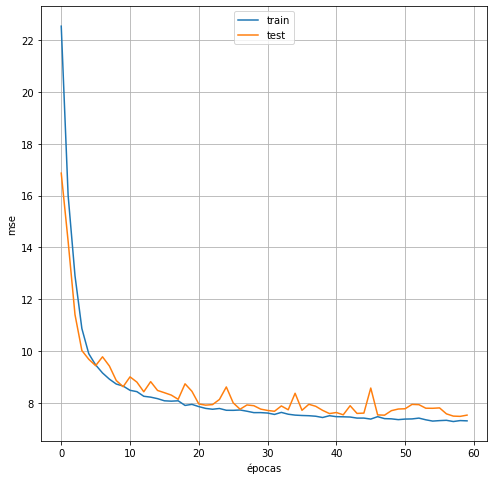

In [25]:
plt.figure(1, figsize=(8,8))

plt.plot(no2_max*np.sqrt(history.history['mean_squared_error']))
plt.plot(no2_max*np.sqrt(history.history['val_mean_squared_error']))

#plt.yscale("log")
#plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('épocas')
plt.grid()
#plt.xlim(-0.5,20.1)
plt.legend(['train', 'test'], loc='upper center')


plt.show()

### Visualización de predicción

La siguiente celda propone una inspección visual de la predicción anterior sobre un rango concreto del test junto al valor del error absoluto para cada hora predicha. El conjunto del test solo ha sido usado para evaluar el entrenamiento de la red nunca para directamente influenciarlo

(4800, 1)


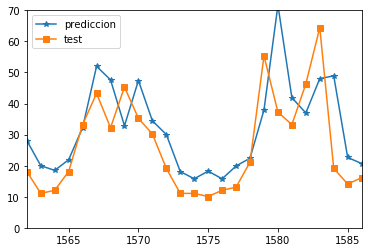

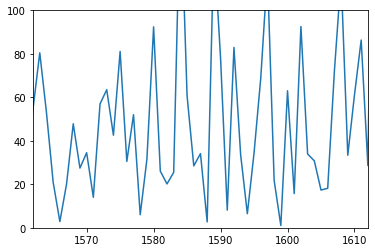

150/150 [==============================] - 1s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[0.0032134721986949444, 0.0032134721986949444]


In [18]:
# Keras ofrece una forma sencilla de predecir y obtener la evaluación en base al error minimizado
predicciones = model.predict(dataSet_lstm_test_input)
precision = model.evaluate(x=dataSet_lstm_test_input,y=no2_lstm_test_target)

rango = 50
t = 1562 # Instante de tiempo respecto el que mostramos la predicción

# Comparación de predicción y test
plt.plot(no2_max*predicciones[:,0],marker='*',label='prediccion')
plt.plot(no2_max*no2_lstm_test_target,marker='s',label='test')
plt.xlim([t,t+rango])
plt.ylim([0,no2_max])
plt.legend()
plt.show()

# Errores relativos absolutos
plt.plot((np.abs(no2_lstm_test_target-predicciones[:,0])/no2_lstm_test_target)*100)
plt.ylim([0,100])
plt.xlim([t,t+50])
plt.show()



### Metricas globales de la predicción para la estructura de red planteada

In [98]:
print('Mean Squared Error')
print(np.mean(np.power((predicciones-no2_lstm_test_target[:,np.newaxis])*no2_max,2)))
print("Comparación del Mean Squared Error con valor medio de la señal")
print(np.mean(np.power((predicciones-no2_lstm_test_target[:,np.newaxis])*no2_max,2)),np.mean(np.power(no2_max*no2_lstm_test_target,2)))
print('Mean Absolute Percentage Error')
print(np.mean(np.abs(predicciones-y_ts[:,np.newaxis])/y_ts[:,np.newaxis])*100)


[0.008061817847192287, 0.008061817847192287, 0.06930379569530487]
112.25275827635973
24.507306355164904


### Se definirá un barrido de modelos para ir almacenandolos y posteriormente evaluarlos

El ejercicio anterior es una muestra puntual de una arquitectura que hace uso de unidades LSTM para predecir la contaminación pero es necesario tratar de encontrar dentro de los parámetros disponibles, la arquitectura que mejor realice la predicción. Se propone aquí como parte del trabajo evaluar el papel que la cantidad de neuronas LSTM y neuronas MLP de sus respectivas capas oculta tiene en la métrica a minimizar por el optmizador. 

Se explora el rango de 20 a 200 neuronas en saltos de 5, incluyendo los extremos. Se promedia para cada arquitectura 5 veces el entrenamiento para obtener una estimación fidedigna de la calidad de la predicción puesto que el entrenamiento al tener una componente estocástica ni asegura lograr el mínimo de error global ni que siempre este sea el mismo.

Por supuesto, este es un rango estimado por la intuición puesto que no existe una regla universal ni sencilla para proponer estructuras de red útiles. Dado que estamos explorando entradas de 24 y 48 horas, de 20 a 200 en dos capas ocultas parece simplemente razonable.

Lo que se hace a continuación es entrenar modelos que serán almacenados en formato h5 para poder acudir a ellos en la evaluación final sin temor a que la variable sea borrada de la memoria antes de ser procesada.

El siguiente script, que va adjunto a este jupyter notebook para poder trabajar en clústers de computación, permite ir calculando concurrentemente la optimización de las distintas arquitecturas en un mismo directorio puesto que lo que hace es de la lista de ficheros totales que se deben generar, solo calcula aquellos que aún no existen de la lista en el directorio.

La función entrenarModelo define la arquitectura de red a entrenar en función de los parámetros de entradas, esto es el número de neuronas LSTM y MLP respectivamente

##### (Comentario final: por limitación de recursos computacionales los resultados para 48 días no están promediados, solo se tiene una única iteración del entrenamiento para cada arquitectura)

In [26]:
def entrenarModelo(nLSTM,nMLP):
    '''
    Entrena modelo segun neuronas introducidas
    '''
    # Base del modelo
    model = Sequential()
    # Incorporamos una capa oculta de celulas LSTM
    model.add((LSTM(nLSTM, activation='relu', return_sequences=True, input_shape=(inputSize, numFeatures))))
    model.add(Flatten()) 
    model.add(Dense(nMLP, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # Se compila con el optimizador
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    
    # Sin mostrar nada por la pàntalla
    history = model.fit(dataSet_lstm_train_input, no2_lstm_train_target, epochs=60, batch_size=300, validation_data=(dataSet_lstm_test_input, no2_lstm_test_target), verbose=2)
    
    # Devolvemos modelo entrenado
    return model


In [27]:
import re
from pathlib import Path


## Incluyen los nombres de los modelos tal como se guardarán y que se 
## buscarán si están almacenados o no para repetir el entrenamiento del modelo
rangoNeuronasLSTM = np.arange(20,205,5)
rangoNeuronasMLP  = np.arange(20,205,5)
print(rangoNeuronasMLP)
posiblesArquitecturas = [[['./modelosBarridoArquitectura/modelo_capaLSTM_n'+str(nLSTM)+'_capaMLP_n'+str(nMLP)+'_iter_n'+str(iter)+'.h5' for nMLP in rangoNeuronasMLP] for nLSTM in rangoNeuronasLSTM] for iter in range(5)]
# Unimos las sublistas con una funcion obtenida de stackoverflow
posiblesArquitecturas = unlist(posiblesArquitecturas)

#osiblesArquitecturas = [nombre for in posiblesArquitecturas]
# El bucle de búsqueda. Se iran eliminando elementos de la lista a medida que se compruebe que existen
while posiblesArquitecturas:
    # Tomamos elemento al azar
    nombreModelo = random.choice(posiblesArquitecturas)
    ficheroModelo = Path(nombreModelo)
    # Comprobar que existe el fichero
    if ficheroModelo.is_file():
        # Existe el fichero, por lo tanto eliminamos de la lista
        posiblesArquitecturas.remove(nombreModelo)
    else:        
        # No existe el fichero, comenzamos creando un fichero dummy para ocupar el nombre
        modelo = Sequential()
        modelo.add(Dense(1, activation='linear',input_shape=(inputSize, numFeatures)))
        modelo.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
        modelo.build()
        modelo.save(nombreModelo)
        
        # Necesitamos extraer primero el número de neuronas del nombre
        nLSTM_re = re.search('capaLSTM_n\d*', nombreModelo)
        nLSTM = nLSTM_re.group(0)[10::]
        nMLP_re = re.search('capaMLP_n\d*', nombreModelo)
        nMLP = nMLP_re.group(0)[9::]
        
        print('Modelo con la siguiente arquitectura: ')
        print(nombreModelo,nLSTM,nMLP)
        
        # Para obtener un promedio iteraremos 5 veces
        modelo = entrenarModelo(int(nLSTM),int(nMLP))

        # Se guarda el Modelo
        print('Se guarda modelo')
        modelo.save(nombreModelo)

        # Finalmente se elimina el fichero
        print('Se elimina elemento')
        posiblesArquitecturas.remove(nombreModelo)
        print("---------")
    # file exists
print('Se han eliminado todos los elementos :',posiblesArquitecturas)


[ 20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 105
 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195
 200]
Modelo con la siguiente arquitectura: 
./modelosBarridoArquitectura/modelo_capaLSTM_n100_capaMLP_n85_iter_n0.h5 100 85
240/240 - 12s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Se guarda modelo
Se elimina elemento
---------
Modelo con la siguiente arquitectura: 
./modelosBarridoArquitectura/modelo_capaLSTM_n25_capaMLP_n40_iter_n3.h5 25 40
240/240 - 6s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Se guarda modelo
Se elimina elemento
---------
Modelo con la siguiente arquitectura: 
./modelosBarridoArquitectura/modelo_capaLSTM_n35_capaMLP_n190_iter_n3.h5 35 190
240/240 - 7s - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Se guarda modelo
Se elimina elemento
---------
Modelo con la siguiente 

KeyboardInterrupt: 

### Evaluación de la exploración de parámetros y presentación

La exploración anterior genera una gran cantidad de datos y la siguiente celda carga los diferentes modelos para obtener la evaluación del mismo, que fundamentalmente devuelve el Mean Square Error sobre el conjunto de test que no cambia para 24 y 48 horas

### 24 horas

In [ ]:
rangoNeuronasLSTM = np.arange(20,205,5)
rangoNeuronasMLP  = np.arange(20,205,5)

### Estimación de mse a partir de las simulaciones obtenidas
posiblesParametrosArquitecturas = np.asarray([[[[nLSTM,nMLP,nIter] for nMLP in rangoNeuronasMLP] for nLSTM in rangoNeuronasLSTM] for nIter in range(5)])
posiblesParametrosArquitecturas = posiblesParametrosArquitecturas.reshape(5*37*37,3)

performance = np.zeros((37,37)) # Eje 0 son las neuronas lstm y el eje 1 las neuronas de la capa densa
for parametros in posiblesParametrosArquitecturas:
    print(parametros)
    # Definimos nombre de modelo
    nMLP = parametros[0]
    nLSTM = parametros[1]
    nIter = parametros[2]
    nombreFichero = '/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n'+str(nLSTM)+'_capaMLP_n'+str(nMLP)+'_iter_n'+str(nIter)+'.h5'
    print(nombreFichero)
    # Cargamos el modelo
    new_model = keras.models.load_model(nombreFichero)
    
    # Se evalua conforme se definió
    precision = new_model.evaluate(x=dataSet_lstm_test_input,y=no2_lstm_test_target)
    performance[np.where(rangoNeuronasLSTM == nLSTM),np.where(rangoNeuronasMLP == nMLP)] += precision[0]

[20 20  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 25  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[20 30  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 35  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 40  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 20 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 20 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n20_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 55  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 60  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[25 65  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 70  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 75  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 25 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 25 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n25_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[30 90  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n30_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[30 95  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n30_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 30 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n30_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n30_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n30_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[35 20  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[35 25  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[35 30  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[35 35  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capa

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 35 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 35 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 35 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n35_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 50  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[40 55  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[40 60  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[40 65  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 70  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 40 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 40 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 40 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n40_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[45 85  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 90  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 95  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 45 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 45 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n45_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[50 20  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[50 25  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 30  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 50 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n50_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 50 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 45  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 50  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 55  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[55 60  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[55 65  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 55 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n55_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 55 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[60 80  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[60 85  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[60 90  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[60 95  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 60 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capa

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 60 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 60 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n60_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[65 20  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n65_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[65 25  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n65_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n65_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n65_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n65_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 40  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[70 45  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[70 50  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[70 55  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 60  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 70 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 70 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[ 70 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n70_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 70 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 3s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[75 75  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[75 80  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[75 85  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[75 90  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[75 95  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 75 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 75 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 75 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n75_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[80 20  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaL

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n80_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n80_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 80 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n80_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n80_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 80 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[85 35  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[85 40  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[85 45  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 50  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 55  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 85 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n85_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[90 70  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[90 75  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[90 80  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[90 85  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 90  0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 90 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n90_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n95_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n95_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n95_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n95_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100  30   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[100  35   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100  40   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[100  45   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  50   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n100_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[105  65   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105  70   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[105  75   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105  80   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105  85   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[105 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[105 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[105 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n105_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n110_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n110_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n110_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n110_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  25   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  30   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  35   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[115  40   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115  45   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[115 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n115_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[115 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120  60   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120  65   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120  70   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[120  75   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120  80   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[120 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[120 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n120_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[125  95   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n125_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n125_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n125_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n125_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130  20   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130  25   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130  30   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130  35   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[130  40   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[130 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[130 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n130_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135  55   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[135  60   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[135  65   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[135  70   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[135  75   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[135 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[135 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[135 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n135_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  90   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n140_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[140  95   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n140_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n140_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[140 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n140_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n140_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145  20   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  25   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  30   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  35   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[145 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n145_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[150  50   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150  55   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[150  60   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150  65   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150  70   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
[150 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[150 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n150_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  85   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  90   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[155  95   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[155 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[155 105   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n155_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160  20   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[160  25   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[160  30   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[160 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[160 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n160_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160 140   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165  45   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[165  50   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[165  55   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[165  60   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[165  65   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[165 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[165 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[165 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n165_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[165 175   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[170  80   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[170  85   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[170  90   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170  95   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[170 100   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[170 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[170 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[170 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n170_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[175  20   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n175_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175  25   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n175_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n175_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[175 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n175_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n175_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 135   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180  40   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180  45   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180  50   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[180  55   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[180  60   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[180 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[180 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n180_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[180 170   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  75   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  80   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  85   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  90   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  95   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[185 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[185 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[185 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n185_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[190  20   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[190 110   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n190_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190 115   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n190_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[190 120   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n190_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190 125   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n190_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190 130   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[195  35   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195  40   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195  45   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[195  50   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195  55   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195 145   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[195 150   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[195 155   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195 160   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n195_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[195 165   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200  70   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200  75   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200  80   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[200  85   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[200  90   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 180   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 185   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 190   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 195   0]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n200_iter_n0.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200 200   0]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n20_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n20_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n20_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n20_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 30  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 35  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[25 40  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 45  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[25 50  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[ 25 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n25_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 65  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[30 70  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 75  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[30 80  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 85  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 30 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 30 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n30_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 30 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 3s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n35_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 35 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n35_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 35 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n35_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n35_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 35 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[40 25  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
[40 30  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 35  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 40  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[40 45  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 40 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 40 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 40 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n40_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[ 40 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[45 60  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 65  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[45 70  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 75  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[45 80  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n45_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 45 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[50 95  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n50_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 50 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n50_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n50_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n50_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 50 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLS

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[55 20  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[55 25  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[55 30  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 35  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 40  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 55 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n55_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 55 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[60 55  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[60 60  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[60 65  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[60 70  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[60 75  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[ 60 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 60 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 60 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 60 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n60_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 60 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[65 90  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n65_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[65 95  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n65_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 65 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n65_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n65_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n65_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 20  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 25  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 30  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 35  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capa

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 70 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 70 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 70 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n70_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[75 50  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[75 55  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[75 60  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[75 65  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[75 70  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 75 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n75_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[80 85  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[80 90  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[80 95  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 80 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 80 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 80 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 80 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n80_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[85 20  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 25  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 30  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 85 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n85_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 45  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 50  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 55  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 60  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[90 65  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[ 90 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 90 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 3s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[ 90 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n90_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[95 80  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[95 85  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[95 90  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[95 95  1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 95 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capa

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[ 95 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n95_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[100  20   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n100_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n100_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n100_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n100_iter_n1.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n100_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[105  35   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105  40   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105  45   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105  50   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105  55   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[105 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[105 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[105 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n105_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110  70   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110  75   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110  80   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110  85   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110  90   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[110 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[110 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n110_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[115 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n115_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n115_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[115 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n115_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n115_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120  30   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120  35   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120  40   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120  45   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120  50   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n120_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[125  65   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[125  70   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0024 - mean_squared_error: 0.0024
[125  75   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[125  80   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125  85   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[125 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[125 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[125 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[125 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n125_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[125 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n130_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n130_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n130_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[130 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n130_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[135  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 0s 2ms/step - loss: 0.2777 - mean_squared_error: 0.2777
[135  30   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[135  35   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135  40   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135  45   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_cap

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[135 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[135 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n135_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[135 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140  60   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  65   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  70   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  75   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[140  80   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[140 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n140_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145  95   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n145_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n145_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n145_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n145_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150  20   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[150  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150  30   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[150  35   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[150  40   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[150 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n150_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[150 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[155  55   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[155  60   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[155  65   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[155  70   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  75   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[155 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[155 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[155 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 3s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[155 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n155_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[155 185   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[160  90   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n160_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[160  95   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n160_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n160_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[160 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n160_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[160 110   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n160_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[165  20   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[165  30   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[165  35   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[165 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[165 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[165 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n165_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[165 145   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[170  50   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[170  55   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170  60   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[170  65   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[170  70   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[170 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[170 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[170 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n170_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[170 180   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175  85   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[175  90   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[175  95   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[175 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[175 105   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 0s 2ms/step - loss: 0.0806 - mean_squared_error: 0.0806
[175 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[175 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n175_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180  20   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[180  30   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[180 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n180_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[180 140   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[185  45   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[185  50   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  55   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  60   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[185  65   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[185 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[185 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[185 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[185 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n185_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185 175   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190  80   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[190  85   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190  90   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[190  95   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[190 100   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[190 190   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[190 195   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[190 200   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n190_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[195  20   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n195_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195  25   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[195 115   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n195_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195 120   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n195_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[195 125   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n195_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195 130   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n195_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[195 135   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[200  40   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200  45   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200  50   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200  55   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200  60   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[200 150   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200 155   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 160   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[200 165   1]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n200_iter_n1.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 170   1]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 75  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[20 80  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[20 85  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 90  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[20 95  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 20 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n20_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[25 20  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaL

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 25 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n25_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n25_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 25 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n25_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n25_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 30  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[30 35  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 40  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[30 45  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[30 50  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 30 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 30 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n30_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[35 65  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[35 70  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[35 75  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[35 80  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[35 85  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 35 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 35 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n35_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 35 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n40_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 40 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n40_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 40 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n40_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 40 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n40_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 40 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 25  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[45 30  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[45 35  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[45 40  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[45 45  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[ 45 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 45 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 45 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n45_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 60  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[50 65  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[50 70  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 75  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[50 80  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 50 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 50 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n50_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[55 95  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n55_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 55 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n55_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n55_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n55_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 55 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLS

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[60 20  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[60 25  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[60 30  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[60 35  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[60 40  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 60 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n60_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[65 55  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[65 60  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[65 65  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[65 70  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[65 75  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 65 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n65_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 65 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 90  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n70_iter_n2.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 95  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n70_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n70_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n70_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[ 70 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 70 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n70_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[75 20  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[75 25  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[75 30  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[75 35  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capa

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 75 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 75 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n75_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 75 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[80 50  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[80 55  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[80 60  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[80 65  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[80 70  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 80 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n80_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[85 85  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[85 90  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[85 95  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 85 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 85 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 85 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n85_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[90 20  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[90 25  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[90 30  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 90 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 90 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 90 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n90_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[95 45  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[95 50  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[95 55  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[95 60  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[95 65  2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 95 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n95_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 95 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  80   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100  85   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100  90   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  95   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[100 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[100 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[100 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n100_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[105  20   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n105_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[105  25   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[105 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n105_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[105 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n105_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[105 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n105_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[105 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n105_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[105 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110  40   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110  45   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110  50   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110  55   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110  60   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[110 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n110_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  75   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  80   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  85   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  90   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[115  95   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[115 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[115 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n115_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120  20   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n120_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[120 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n120_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[120 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n120_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[120 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n120_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[120 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[125  35   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125  40   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[125  45   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125  50   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[125  55   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[125 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[125 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[125 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n125_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[125 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130  70   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[130  75   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130  80   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[130  85   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[130  90   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[130 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034
[130 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[130 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n130_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[130 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[135 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n135_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[135 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n135_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n135_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n135_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[135 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  30   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  35   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140  40   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[140  45   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140  50   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[140 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[140 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[140 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n140_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[140 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  65   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  70   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[145  75   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[145  80   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[145  85   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[145 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[145 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[145 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[145 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n145_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[145 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[150 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n150_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n150_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[150 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n150_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[150 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n150_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[150 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  25   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[155  30   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[155  35   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  40   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155  45   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[155 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[155 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[155 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[155 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n155_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[155 155   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 14ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[160  60   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[160  65   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160  70   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160  75   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160  80   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[160 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[160 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n160_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[160 190   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165  95   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n165_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n165_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[165 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n165_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[165 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n165_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[165 115   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo

150/150 [==============================] - 2s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[170  20   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170  25   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[170  30   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[170  35   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170  40   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[170 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[170 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[170 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n170_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[170 150   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175  55   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[175  60   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175  65   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[175  70   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034
[175  75   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[175 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[175 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n175_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[175 185   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[180  90   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n180_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[180  95   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n180_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n180_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n180_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 110   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[180 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n180_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  20   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[185  25   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[185  30   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185  35   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[185 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[185 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[185 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[185 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n185_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[185 145   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[190  50   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[190  55   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[190  60   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[190  65   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033
[190  70   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[190 160   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[190 165   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[190 170   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[190 175   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n190_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[190 180   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[195  85   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[195  90   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[195  95   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[195 100   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[195 105   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[195 195   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[195 200   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n195_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[200  20   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[200  25   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[200  30   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[200 120   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[200 125   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[200 130   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[200 135   2]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n200_iter_n2.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[200 140   2]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 45  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 50  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[20 55  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 60  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[20 65  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 20 155   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 160   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 20 165   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 170   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n20_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 20 175   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[25 80  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[25 85  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 90  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[25 95  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 25 100   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capa

150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[ 25 190   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 25 195   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 25 200   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n25_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[30 20  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n30_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[30 25  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_

150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 30 115   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n30_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 30 120   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n30_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 30 125   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n30_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 30 130   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n30_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 30 135   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[35 40  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[35 45  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[35 50  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[35 55  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[35 60  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 150   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 155   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 160   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 165   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n35_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 35 170   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 75  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 80  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[40 85  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[40 90  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[40 95  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 40 185   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 190   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 40 195   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 40 200   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n40_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[45 20  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaL

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 45 110   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n45_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 45 115   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n45_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 45 120   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n45_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 45 125   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n45_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 45 130   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 35  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[50 40  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 45  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 50  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[50 55  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 50 145   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 150   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 50 155   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 50 160   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n160_capaMLP_n50_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 50 165   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[55 70  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 75  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 80  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 85  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[55 90  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 55 180   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 185   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 55 190   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 55 195   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n195_capaMLP_n55_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 55 200   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 60 105   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n60_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 60 110   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n60_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 60 115   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n60_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 60 120   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n120_capaMLP_n60_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 60 125   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[65 30  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[65 35  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[65 40  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[65 45  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[65 50  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 140   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 65 145   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 65 150   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 65 155   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n155_capaMLP_n65_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 65 160   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 65  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 70  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 75  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 80  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[70 85  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n85_capaMLP_

150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 175   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 70 180   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 70 185   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 70 190   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n190_capaMLP_n70_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[ 70 195   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 75 100   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n75_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 105   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n75_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 75 110   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n75_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[ 75 115   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n115_capaMLP_n75_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 75 120   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[80 25  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[80 30  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[80 35  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[80 40  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[80 45  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n45_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 80 135   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 140   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 80 145   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 80 150   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n150_capaMLP_n80_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 80 155   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[85 60  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[85 65  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[85 70  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 75  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n75_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[85 80  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n80_capaMLP_

150/150 [==============================] - 2s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 85 170   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 175   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[ 85 180   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 85 185   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n185_capaMLP_n85_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 85 190   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[90 95  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n90_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 100   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n90_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[ 90 105   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n90_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 110   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n110_capaMLP_n90_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 90 115   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLS

150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[95 20  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[95 25  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[95 30  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[95 35  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n35_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[95 40  3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n40_capaMLP_

150/150 [==============================] - 2s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031
[ 95 130   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 135   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 140   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[ 95 145   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n145_capaMLP_n95_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[ 95 150   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  55   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  60   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  65   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  70   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n70_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100  75   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[100 165   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n165_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[100 170   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n170_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0028
[100 175   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n175_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[100 180   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n180_capaMLP_n100_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0030 - mean_squared_error: 0.0030
[100 185   3]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[105  90   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n90_capaMLP_n105_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105  95   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n95_capaMLP_n105_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105 100   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n100_capaMLP_n105_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105 105   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n105_capaMLP_n105_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[105 110   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_

150/150 [==============================] - 2s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029
[105 200   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n200_capaMLP_n105_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110  20   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n20_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110  25   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n25_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110  30   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n30_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110  35   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_c

150/150 [==============================] - 2s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[110 125   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n125_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110 130   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n130_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110 135   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n135_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027
[110 140   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n140_capaMLP_n110_iter_n3.h5
150/150 [==============================] - 2s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[110 145   3]
/data/julugom/modelosBarridoArquitectura_24horas/model

150/150 [==============================] - 2s 12ms/step - loss: 0.0032 - mean_squared_error: 0.0032
[115  50   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n50_capaMLP_n115_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026
[115  55   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n55_capaMLP_n115_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[115  60   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n60_capaMLP_n115_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035
[115  65   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_capaLSTM_n65_capaMLP_n115_iter_n3.h5
150/150 [==============================] - 2s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025
[115  70   3]
/data/julugom/modelosBarridoArquitectura_24horas/modelo_ca

### 48 horas

In [ ]:
rangoNeuronasLSTM = np.arange(20,205,5)
rangoNeuronasMLP  = np.arange(20,205,5)

### Estimación de mse a partir de las simulaciones obtenidas
posiblesParametrosArquitecturas = np.asarray([[[[nLSTM,nMLP,nIter] for nMLP in rangoNeuronasMLP] for nLSTM in rangoNeuronasLSTM] for nIter in range(5)])
posiblesParametrosArquitecturas = posiblesParametrosArquitecturas.reshape(5*37*37,3)

performance48 = np.zeros((len(rangoNeuronasLSTM),len(rangoNeuronasMLP))) # Eje 0 son las neuronas lstm y el eje 1 las neuronas de la capa densa
for parametros in posiblesParametrosArquitecturas:
    print(parametros)
    # Definimos nombre de modelo
    nMLP = parametros[0]
    nLSTM = parametros[1]
    nIter = parametros[2]
    nombreFichero = '/data/julugom/modelosBarridoArquitectura_48horas/modelo_capaLSTM_n'+str(nLSTM)+'_capaMLP_n'+str(nMLP)+'_iter_n'+str(nIter)+'.h5'
    print(nombreFichero)
    # Cargamos el modelo
    new_model = keras.models.load_model(nombreFichero)
    
    # Se evalua conforme se definió
    precision = new_model.evaluate(x=dataSet_lstm_test_input,y=no2_lstm_test_target)
    performance48[np.where(rangoNeuronasLSTM == nLSTM),np.where(rangoNeuronasMLP == nMLP)] += precision[0]

### Presentación de resultados

Los resultados anteriores, almacenados en las variables performance y performance 48 horas, son guardados en sendos .csv y presentados en forma de mapas de calor

### Aplicaciones.

La regresión horaria lo que nos permite, al emplear datos horarios, es usar información de alta resolución temporal para poder predecir a corto plazo la calidad del aire. Normalmente los pronósticos desde un punto de vista social tienen valor con la mirada puesta a un día, como mínimo, puesto que permiten organizar con cierta maniobrabilidad la gestión de posibles eventos de baja calidad de aire. 

Por ello una aplicación inmediata que muestro es la predicción de la calidad diaria, en lugar de horaria, componiendo predicciones horarias sucesivas. Es decir, si queremos predecir la contaminación del aire promedio del día x, usamos las 24 horas del día x-1 para predecir la contaminación en x:00:00AM, luego empleamos dicha predicción para incorporar la estimación a una nueva ventana temporal de 24 horas y predecir x:01:00AM, y así sucesivamente hasta tener la predicción para x:23:00PM. Finalmente, obtener el valor medio y comparar con el valor diario promedio real. 

En condiciones normales, no tiene sentido esta operación si se espera incorporar en la entrada los datos meteorológicos o del Ozono puesto que no se tienen, pero puede darse el caso de tener simulaciones meteorológicas que dispongan de dicha información horaria para poder sustentar una predicción a futuro como la expuesta anteriormente.

Se emplea la arquitectura de entrada a 24 horas con L neuronas LSTM y M neuronas MLP obtenidas del barrido de modelos como las que mejor predicen la señal.

Se visualiza este cálculo para los días del 25 de diciembre de 2020 al 2 de Enero de 2021

### Comparación con métodos más simples de predicción.

Hemos realizado una predicción básandonos en minimizar el error cuadrático medio. Vamos a comparar con el método de suponer una señal de ruido blanco con media y desviación estándar la señal global del no2 disponible, el método "inocente" de predecir el valor futuro con el valor inmediatamente anterior, el promedio de la ventana de tiempo de entrada y también al de una red de dos capas ocultas densas empleando el número de neuronas estimadas como más eficiente.

También se muestra gráficamente estos resultados con un pequeño subconjunto de la señal

In [99]:
y_ts_naive = np.asarray([no2_pc[365*6-1+i]for i in range(len(y_ts))])
y_ts_aver = np.asarray([np.mean(no2_pc[365*6-30+i:365*6+i]) for i in range(len(y_ts))])
ruido_dataset =np.random.normal(np.mean(no2_pc), np.std(no2_pc), size=len(y_ts)) 
ruido_input = np.asarray([np.random.normal(np.mean(no2_pc[365*6-30+i:365*6+i]), np.std(no2_pc[365*6-30+i:365*6+i]), size=1) for i in range(len(y_ts))])

In [100]:

print(np.mean(np.power((y_ts_naive-y_ts)*no2_max,2)))
print(np.mean(np.abs(y_ts_naive-y_ts)/y_ts)*100)
print("--")

print(np.mean(np.power((y_ts_aver-y_ts)*no2_max,2)))
print(np.mean(np.abs(y_ts_aver-y_ts)/y_ts)*100)
print("--")

print(np.mean(np.power((ruido_dataset-y_ts)*no2_max,2)))
print(np.mean(np.abs(ruido_dataset-y_ts)/y_ts)*100)
print("--")

print(np.mean(np.power((ruido_input-y_ts)*no2_max,2)))
print(np.mean(np.abs(ruido_input-y_ts)/y_ts)*100)

440.53454482210043
44.90655423282928
--
241.55726552677098
35.0880521462027
--
576.7346043762717
47.77145767939895
--
447.9666413129788
45.04696689573119


### Conclusiones

Se han empleado los datos horarios de calidad del aire y meteorología del portal de datos abiertos de Madrid para un trabajo de valor científico en la predicción de la calidad del aire. 

Se han creado codigos de carácter general para el aprovechamiento inmediato de los datos brutos presentados en la web del portal, que se encuentran en un formato no inmediatamente aplicable para las herramientas de aprendizaje automático. Como ejemplo se plantea el caso del NO2 en plaza del Carmen, Madrid centro, usando como variables auxiliares el Ozono, la temperatura, la presión, la humedad relativa, la insolación solar, la velocidad del viento y la dirección del viento. Es facilmente extrapolable a cualquier otra estacion de monitoreo o el análisis de otro contaminante empleando los códigos anteriores. 

El conjunto de datos entrenado se ha empleado para entrenar una red con dos capas ocultas. La primera capa emplea neuronas LSTM para extraer la información temporal presente en la serie disponible global. 

Se ha realizado un barrio en el número de neuronas LSTM y MLP para estimar que instancia de la arquitectura propuesta tiene mejor capacidad de predicción. La métrica empleada ha sido el error medio cuadrático y el criterio inicial para evaluar la calidad de la predicción es aquella configuración que minimice dicha cantidad. 

Se ha explorado la predicción empleando ventanas de tiempo de 24 y 48 horas (24 y 48 coordenadas por cada carácteristica de la entrada). 